# Libraries

In [127]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import swifter
from sklearn.ensemble import RandomForestClassifier  # For classification tasks
from sklearn.ensemble import RandomForestRegressor   # For regression tasks
from sklearn.metrics import accuracy_score, mean_squared_error
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from textblob import TextBlob
import nltk
print(nltk.data.find('tokenizers/punkt'))
nltk.data.path.append('/Users/rebeccageisberg/nltk_data')
# Redownload 'punkt' directly to this path
nltk.download('punkt', download_dir='/Users/rebeccageisberg/nltk_data')

from textblob import download_corpora
download_corpora.download_all()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

/Users/rebeccageisberg/nltk_data/tokenizers/punkt


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/rebeccageisberg/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]   

# Loading the Files

Download the csv files into the `data/` directory.

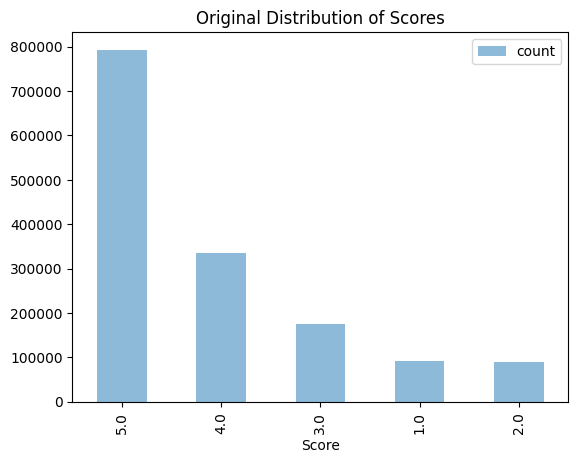

/var/folders/f9/726yn4bj70g510l3wf22lp340000gn/T/ipykernel_80245/1853340413.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=30000, random_state=42))


Number of 1-star reviews: 89000
Number of 2-star reviews: 89000
Number of 3-star reviews: 89000
Number of 4-star reviews: 89000
Number of 5-star reviews: 89000


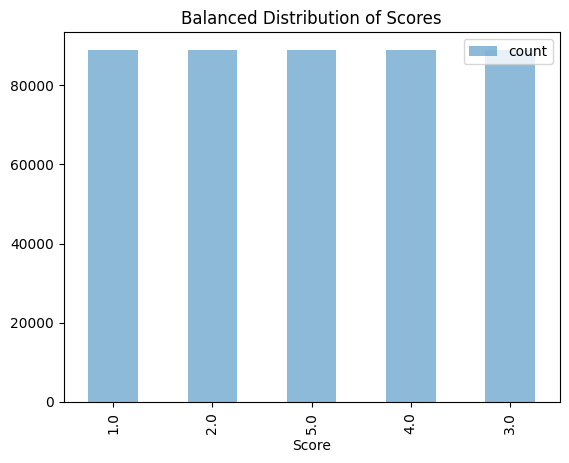


Balanced training set shape: (657192, 9)
Balanced training set is ready for use!

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [123]:
trainingSet = pd.read_csv("data/train.csv")
testingSet = pd.read_csv("data/test.csv")

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Original Distribution of Scores")
plt.show()

#here we want to balance the training set!! this is because the training set is too big and i just dont 
#want to deal, so i am going to make it smaller and downsize the 5 star reviews becaused there are too many of them!! :)


# Collect all reviews in a list

# Define the review threshold for each star rating (e.g., 10,000 reviews per rating)
review_threshold = 89000

# Step 1: Start with all Ids from the testingSet, but instead of concatenating directly, collect reviews in a list
collected_reviews = []

# Step 2: Include all reviews from testingSet Ids first
for id_value in testingSet['Id']:
    # Get all reviews for this Id from the train set
    id_reviews = trainingSet[trainingSet['Id'] == id_value]
    collected_reviews.append(id_reviews)

# Step 3: For each star rating (1 to 5 stars), add reviews from the trainingSet until the threshold is met
for rating in [1, 2, 3, 4, 5]:
    rating_reviews = trainingSet[trainingSet['Score'] == rating]
    
    # Count how many reviews for this rating are already in the balanced set
    current_count = sum([df[df['Score'] == rating].shape[0] for df in collected_reviews])
    
    # Calculate how many more reviews are needed to reach the threshold
    reviews_needed = review_threshold - current_count
    
    if reviews_needed > 0:

        if reviews_needed > len(rating_reviews):
            reviews_needed = len(rating_reviews)

        # Sample additional reviews from the remaining trainingSet for this rating
        additional_reviews = rating_reviews.sample(reviews_needed, replace=False, random_state=42)
        
        # Add the sampled reviews to the collected reviews
        collected_reviews.append(additional_reviews)

# Step 4: Once all reviews are collected, concatenate them into one DataFrame
balanced_training_set = pd.concat(collected_reviews).sample(frac=1, random_state=42).reset_index(drop=True)

balanced_subset = (
    balanced_training_set
    .groupby('Score')
    .apply(lambda x: x.sample(n=30000, random_state=42))
    .reset_index(drop=True)
)

# Save the sampled balanced dataset to CSV
balanced_subset.to_csv("balanced_training_subset.csv", index=False)

# Loop through each star rating (1 to 5 stars) and print the number of reviews
for rating in [1, 2, 3, 4, 5]:
    review_count = balanced_training_set[balanced_training_set['Score'] == rating].shape[0]
    print(f"Number of {rating}-star reviews: {review_count}")


# Step 5: Plot the distribution of ratings in the final balanced set
balanced_training_set['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Balanced Distribution of Scores")
plt.show()

# Step 6: Final output
print()
print("Balanced training set shape:", balanced_training_set.shape)
print("Balanced training set is ready for use!")


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

Pandas Apply: 100%|██████████| 657192/657192 [00:06<00:00, 108374.88it/s]


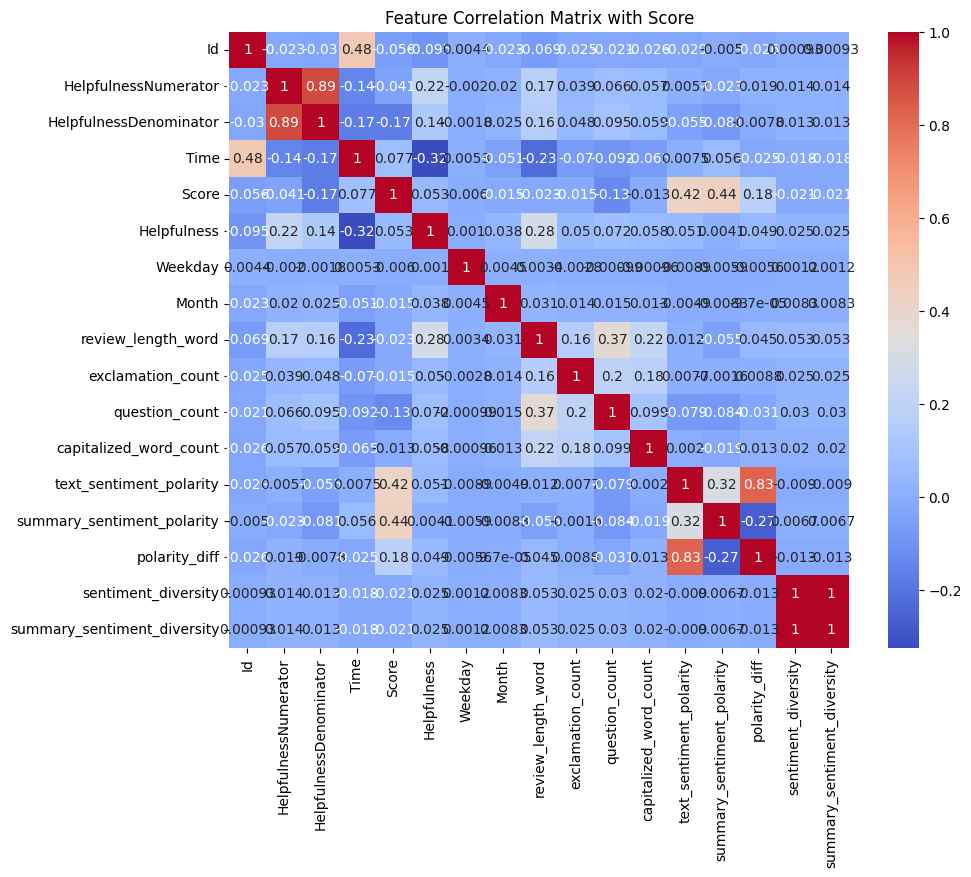

train shape: (657192, 21)
testingSet shape: (212192, 2)
First few Ids in train:
        Id
0  1248981
1   175813
2   223925
3  1344283
4   305114
First few Ids in testingSet:
        Id
0  1323432
1  1137299
2  1459366
3   931601
4  1311995
Data type of Id in train: int64
Data type of Id in testingSet: int64
Number of common Ids between train and testingSet: 212192
X_submission shape after merge: (212192, 22)
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   223925  6300217027   AVTVARULU85KO                     0   
1  1344283  B003FSTN52  A1VFTT1ZX19UF3                     0   
2   766206  B0000AQS0F   ATJZKQJA9CJ35                     0   
3  1416668  B004LWZW8I  A3QCC2MD5C8RST                     1   
4   227578  6300248143  A28GRFVAA4DU5P                     3   

   HelpfulnessDenominator        Time  \
0                       0  1377302400   
1                       1  1371168000   
2                       0  1396742400   
3                       2  1331078400 

In [153]:
 analyzer = SentimentIntensityAnalyzer()
def calculate_sentiment_diversity(summary):
    # Ensure the input is a string (to avoid errors if there are missing values)
    if not isinstance(summary, str):
        return 0.0
    
    # Split the summary into sentences (split on periods)
    sentences = summary.split('.')
    
    # Calculate polarity for each sentence using VADER
    polarities = [analyzer.polarity_scores(sentence)['compound'] for sentence in sentences if sentence]
    
    # Calculate the variance of polarities
    if len(polarities) > 1:
        sentiment_diversity = np.var(polarities)
    else:
        sentiment_diversity = 0.0  # No variance for single-sentence summaries
    
    return sentiment_diversity


def add_features_to(df):
    # This is where you can do all your feature extraction
   
    df['Text'] = df['Text'].fillna("").astype(str)

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # df['review_length_char'] = df['Text'].apply(len)

    df['Weekday'] = pd.to_datetime(df['Time'], unit='s').dt.day_name()
    df['Month'] = pd.to_datetime(df['Time'], unit='s').dt.month_name()

    dayMap = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5,
              'Saturday': 6, 'Sunday': 7}
    monthMap = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June':6, 
                'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11,
                'December': 12}

    df['Weekday'] = df['Weekday'].map(dayMap)
    df['Month'] = df['Month'].map(monthMap)

    
    # Word count as a feature
    df['review_length_word'] = df['Text'].apply(lambda x: len(x.split()))

    # keywords = ["average", "okay", "mid", "mediocre"]
    # for word in keywords:
    #     df[f'contains_{word}'] = df['Text'].apply(lambda x: int(word in x.lower()))

    df['exclamation_count'] = df['Text'].apply(lambda x: x.count('!'))
    df['question_count'] = df['Text'].apply(lambda x: x.count('?'))
    df['capitalized_word_count'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))

    #text_sentiment_scores = df['Text'].swifter.apply(lambda x: analyzer.polarity_scores(str(x)))
    #df['text_sentiment_polarity'] = text_sentiment_scores.apply(lambda x: x['compound'])

    #summary_sentiment_scores = df['Summary'].swifter.apply(lambda x: analyzer.polarity_scores(str(x)))
    df['summary_sentiment_diversity'] = df['Summary'].apply(calculate_sentiment_diversity)

    df['polarity_diff'] = df['text_sentiment_polarity'] - df['summary_sentiment_polarity']

    df['sentiment_diversity'] = df['Summary'].swifter.apply(calculate_sentiment_diversity)
    
    # Apply VADER sentiment analysis only once per row
    # sentiment_scores = df['Text'].swifter.apply(lambda x: analyzer.polarity_scores(str(x)))
    # df['sentiment_polarity'] = sentiment_scores.apply(lambda x: x['compound'])
    # df['sentiment_positive'] = sentiment_scores.apply(lambda x: x['pos'])
    # df['sentiment_neutral'] = sentiment_scores.apply(lambda x: x['neu'])
    # df['sentiment_negative'] = sentiment_scores.apply(lambda x: x['neg'])


    # Correlation matrix visualization (optional)
    if 'Score' in df.columns:
        numeric_df = df.select_dtypes(include=[float, int])  # Select only numeric columns
        correlation_matrix = numeric_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title("Feature Correlation Matrix with Score")
        plt.show()


    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(balanced_training_set)

    # **Debug: Check the shapes and ID columns in train and testingSet**
    print("train shape:", train.shape)
    print("testingSet shape:", testingSet.shape)
    # **Check the first few rows of the Id columns in both datasets**
    print("First few Ids in train:")
    print(train[['Id']].head())
    print("First few Ids in testingSet:")
    print(testingSet[['Id']].head())
    # **Check if the data types of the Id column are consistent**
    print("Data type of Id in train:", train['Id'].dtype)
    print("Data type of Id in testingSet:", testingSet['Id'].dtype)

    common_ids = set(train['Id']).intersection(set(testingSet['Id']))
    print(f"Number of common Ids between train and testingSet: {len(common_ids)}")


    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')

    # **Debug: Check the shape and contents of X_submission after merging**
    print("X_submission shape after merge:", X_submission.shape)
    print(X_submission.head())  # Inspect the first few rows

    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    
    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]
    
    print("Columns in X_train:")
    for col in X_train.columns:
        print(f"'{col}'")

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [154]:


# print("Columns in X_train:")
# for col in X_train.columns:
#     print(f"'{col}'")

# if 'Score' in X_train.columns:
#     X_train = X_train.drop(columns=['Score'])
# else:
#     print("'Score' column not found in X_train!")

# dont touch 
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
) 

# Feature Selection

In [155]:
features = [ 'HelpfulnessDenominator', 'Weekday', 'Month', 'review_length_word', 'exclamation_count',
            'question_count', 'capitalized_word_count', 'summary_sentiment_polarity',
            'polarity_diff', 'sentiment_diversity'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


# Model Creation

In [156]:
# # Learn the model
# model = KNeighborsClassifier(n_neighbors=15).fit(X_train_scaled, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_scaled)
# dont touch abouve 

# k_values = list(range(70,90,5))

# # Dictionary to store the mean F1-weighted scores for each k
# k_results = {}

# # Loop through each k value
# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k)  # Initialize with only k specified
#     scores = cross_val_score(knn, X_train_scaled, Y_train, cv=3, scoring='f1_weighted', n_jobs=-1)  # Cross-validate
#     k_results[k] = scores.mean()  # Store the mean F1-weighted score
#     print(f"k = {k}, Mean F1-weighted score = {scores.mean():.4f}")

# # Identify the best k value based on cross-validated scores
# best_k = max(k_results, key=k_results.get)
# print("\nBest k from initial search:", best_k)

# # Train the model using the best k value found
# best_knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train_scaled, Y_train)

# # Predict on the test set
# Y_test_predictions = best_knn_model.predict(X_test_scaled)

# Define the range of values for n_estimators and max_depth to search
n_estimators_values = range(80,150, 10)  # Number of trees in the forest
max_depth_values = [10, 15, 20]     # Depth of each tree (None for no limit)

# Dictionary to store the mean F1-weighted scores for each (n_estimators, max_depth) combination
rf_results = {}

# Loop through each combination of n_estimators and max_depth
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        # Initialize the RandomForestClassifier with current n_estimators and max_depth
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
        # Cross-validate using 3-fold CV and calculate mean F1-weighted score
        scores = cross_val_score(rf, X_train_select, Y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
        rf_results[(n_estimators, max_depth)] = scores.mean()
        
        # Print the results for this combination
        print(f"n_estimators = {n_estimators}, max_depth = {max_depth}, Mean F1-weighted score = {scores.mean():.4f}")

# Identify the best (n_estimators, max_depth) combination based on cross-validated scores
best_params = max(rf_results, key=rf_results.get)
best_n_estimators, best_max_depth = best_params
print("\nBest parameters from initial search: n_estimators =", best_n_estimators, ", max_depth =", best_max_depth)

# Train the RandomForest model using the best parameters found
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
best_rf_model.fit(X_train_select, Y_train)

# Predict on the test set
Y_test_predictions = best_rf_model.predict(X_test_select)


n_estimators = 80, max_depth = 10, Mean F1-weighted score = 0.4164
n_estimators = 80, max_depth = 15, Mean F1-weighted score = 0.4216
n_estimators = 80, max_depth = 20, Mean F1-weighted score = 0.4143
n_estimators = 90, max_depth = 10, Mean F1-weighted score = 0.4167
n_estimators = 90, max_depth = 15, Mean F1-weighted score = 0.4216
n_estimators = 90, max_depth = 20, Mean F1-weighted score = 0.4143
n_estimators = 100, max_depth = 10, Mean F1-weighted score = 0.4170
n_estimators = 100, max_depth = 15, Mean F1-weighted score = 0.4218
n_estimators = 100, max_depth = 20, Mean F1-weighted score = 0.4148
n_estimators = 110, max_depth = 10, Mean F1-weighted score = 0.4171
n_estimators = 110, max_depth = 15, Mean F1-weighted score = 0.4218
n_estimators = 110, max_depth = 20, Mean F1-weighted score = 0.4152
n_estimators = 120, max_depth = 10, Mean F1-weighted score = 0.4171
n_estimators = 120, max_depth = 15, Mean F1-weighted score = 0.4221
n_estimators = 120, max_depth = 20, Mean F1-weighted s

# Model Evaluation

Accuracy on testing set =  0.4311370786516854


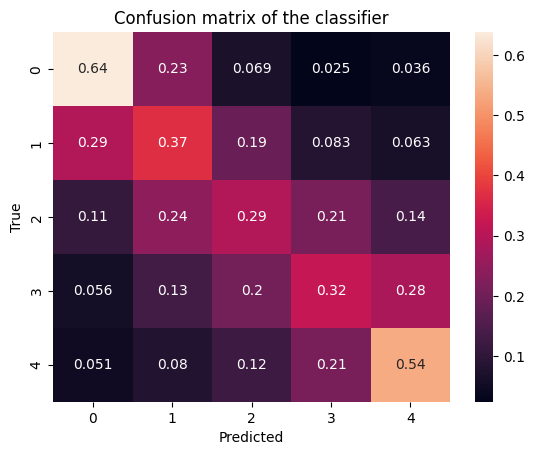

In [157]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [138]:
# Create the submission file
X_submission['Score'] = best_rf_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)